In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from pathlib import Path
from sklearn.ensemble import ExtraTreesRegressor

from sklearn import metrics

# Lesson 2

## 00:00:00 - What's coming

* So far all we've learned: there's a thing called Random Forests that works quite well for some datasets.
  * Diving deeper into RFs next.
* After: how do we interpret Random Forests to understand our data?

## 00:00:45 - Review

* Learned about Fast.ai library.
  * Highly opinionated: lots of research for best practises.
* Lots of wrappers on top of existing code.
* Most of today is about getting stuff into and out of Scikit-learn.

## 00:01:44 - Fast.ai library

* Set of notebooks under `fastai/courses/ml1`.
* In that directory, there's a symlink to the parent `fastai` package directory.
* If you want to use Fast.ai library, need to symlink:
  ``ln -s ../fastai fastai``
  
## 00:03:35 - Audience question

* Q1: Do you create symlinks with `ln -s`?
* A1: Yes: `ln -s <source> <dest>`.
  * Similar to shortcut in Windows and alias in Mac.
  
## 00:05:29 - Bluebooks revisited 

* Important to deeply understand evaluation metric for the project.
* In this case it's root mean log squared error: `sqrt(log(acts) - log(preds))**2`

In [2]:
PATH = Path('./data/bluebook/')

In [3]:
df_raw = pd.read_csv(f'{PATH}/Train.csv', low_memory=False, parse_dates=['saledate'])

In [4]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
add_datepart(df_raw, 'saledate')

In [6]:
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [7]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

Can use `train_cats` from the Fast.ai library to replace strings with categories.

In [8]:
train_cats(df_raw)

In [9]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

Let's you easily convert categories to codes.

In [10]:
df_raw.UsageBand.cat.codes[:4]

0    1
1    1
2    0
3    0
dtype: int8

`proc_df` will convert categorical columns into codes, convert missing values with the median and add a column that tell you if a value is missing or not.

In [11]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')

In [12]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.9831044622669224

### 00:10:50 - $r^2$

* $R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$
* Model tells you how much better you are than just predicting the mean.
* Range of values is 1 and below: possible to make a model much worse than the mean.

### 00:17:32 - Measuring overfitting

* With only training performance, you don't know if your model is going to generalise well.

<img src="./images/underfitting-vs-overfitting.png" width=600px>

  * Aka: overfitting
 
* To solve this problem: create a good validation.
* Validation set should be as similiar as possible to validation set.
  * Time series: validation set should be the same time frame as a test set if possible.
  
* In real world: test set should not be looked at while training model. Should only be looked at at the very end of the project.

In [13]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_trn = len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, X_train.shape, X_valid.shape

((389125, 66), (389125, 66), (12000, 66))

#### 00:23:56 - Audience questions

* Q1: For categorical data, should you convert them into different columns: aka one-hot encoding.
* A1: Will be covered later.

* Q2: Re dividing set into train and validation, why not use pick them randomly?
* A2: Because it is closer to the Kaggle test set: a random validation set would be much easier.

* Q3: If our $r^2$ turns out bad on validation set and we keep trying to improve it, wouldn't we overfit our validation set?
* A3: That's the point of the test set and actually Kaggle has a 4th set to deal with overfitting on the test set.

In [14]:
def rmse(x, y): return math.sqrt(((x-y) ** 2).mean())

m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)

print(f'RMSE train: {rmse(m.predict(X_train), y_train)}')
print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

CPU times: user 1min 28s, sys: 1.06 s, total: 1min 29s
Wall time: 19.4 s
RMSE train: 0.09058650464539587
RMSE val: 0.24969205971085992
R^2 val: 0.8886584051772132


## 00:27:08 - Fast.ai style guide (why not use PEP8?)

* Being able to look at something in one go has a lot of value.
* Consistently use certain letters to mean certain things makes sense in data science.
* Should still know and use PEP8 as a software engineer.

## 00:29:28 - Speeding up training and development

* Rule of thumb: if something takes more than 10 secs to run, it's too long to run interactively analysis.
  * Solution: train on a smaller dataset while experimenting.
  * Can pass `subset` param to `proc_df` to reduce the sample size.
  * Want to ensure you resplit your validation set (otherwise it's cheating).

In [15]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [16]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)

print(f'RMSE train: {rmse(m.predict(X_train), y_train)}')
print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

CPU times: user 2.76 s, sys: 38 ms, total: 2.79 s
Wall time: 692 ms
RMSE train: 0.11212894704774892
RMSE val: 0.36895426363850503
R^2 val: 0.7568954759985358


## 00:31:50 - Viewing a single tree

* "Forest is made of trees"
* In Scikit-learn, trees are called estimators.

In [17]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

RMSE val: 0.5814947072343097
R^2 val: 0.3961354899757379


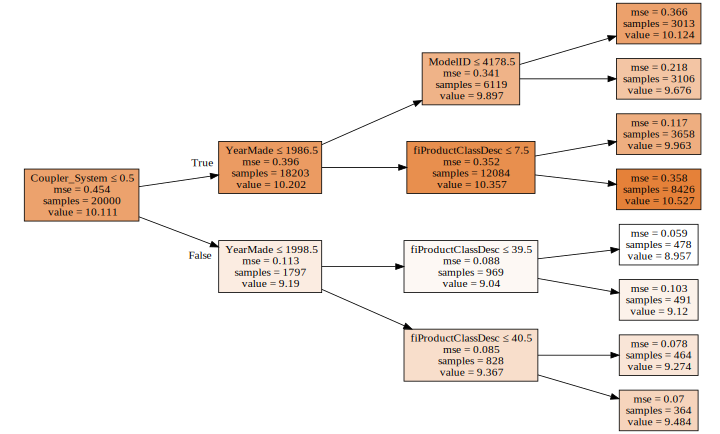

In [18]:
draw_tree(m.estimators_[0], df_trn, precision=3)

* Algorithm has determined that the best split it can make is the `Coupler_System` split at 0.5.
* Uses weighted average of the MSE of the two groups to determine if a split is good or not.
  * Then for the remaining features, it trys to find the next best split.
* Stop when you hit some limit (`max_depth=3`) or when leaf nodes only have 1 thing in them.
  * Can do that by removing the `max_depth` param:

In [19]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [20]:
print(f'RMSE train: {m.score(X_train, y_train)}')
print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

RMSE train: 1.0
RMSE val: 0.4887548244550871
R^2 val: 0.5733909260779704


* Which gives us a perfect RMSE value, but obviously overfits a lot (though still performs better than `max_depth`).
* Approach to making trees better: forests.

## 00:47:08 - Bagging

* Forests uses a statistical technique called "bagging".
* Random Forests = "way of bagging trees".
* Bagging:
  * Idea of creating multiple models that are predictive but not correlated with each other.
  * What if you created massive deep trees on only a small subset of the data (similar to the overfit tree above)?
    * That's what a random forest does.
    * All have errors but when averaged they should cancel each other out (in theory).
* By default, `RandomForestRegressor` creates 10 "estimators" (aka random trees).

In [21]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print(f'R^2 train: {m.score(X_train, y_train)}')
print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

R^2 train: 0.9728962882813472
RMSE val: 0.3739052335758413
R^2 val: 0.7503272975525497


### 00:51:27 - Audience questions

* Q1: Are we taking 10 crappy models on random subsets and combining them to create a good model?
* A1: Yes.

* Q2: Is there a certain number of trees you need to get a good RMSE?
* A2: Will look at hyperparameters soon.

* Q3: Can subsets have overlap?
* A3: Scikit-learn, picks out n rows with "replacement", which means that on average 63.2% of rows are represented.

* Q4: Is a tree simply finding points most like your current point?
* A4: Yes, but you're trying to find a model which tells you which variables are important and how they work together.

### 00:56:06 - ExtraTreesRegressor and uncorrelated trees

* Want each individual tree to be predictive but uncorrelated.
  * Talked about by original paper author in late 90s.
* Recent research found that less correlated is more important than less predictive.
  * Another class called `ExtraTreesRegressor` uses an "extremely randomised tree" model which randomly tries a few splits of a few variables, so it's faster and can build more trees.

In [22]:
m = ExtraTreesRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print(f'R^2 train: {m.score(X_train, y_train)}')
print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')
print(f'R^2 val: {m.score(X_valid, y_valid)}')

R^2 train: 1.0
RMSE val: 0.36479917516633253
R^2 val: 0.7623402317086848


### 00:58:02 - Audience questions

* Q1: What do you mean by uncorrelated trees?
* A1: If I build 1000 trees on 10 different datapoints, it's likely that each tree will be very different to each other.

* Q2: When should you use a `RandomForest` over an `ExtraTreesRegressor`?
* A2: That's hyperparameter tuning which we'll cover later.

* Q3: How do splits work with continuous values?
* A3: Each node has the average of all the nodes in the tree and uses that to figure out the optimial split.

* Q4: How do you find the optimal split?
* A4: Try each data point - CPUs are fast.

* Q5: Do we always use average each tree node?
* A5: There are other types of trees with leaf nodes that are independant linear regressions but not common in practise.

* Q6: If you have many trees with many leaf nodes across trees, how do you find the average across the validation set?
* A6: For each node, you run it through each tree to find the value where it lands and do for each tree. You then average the tree 

## 01:04:28 - Examining trees in forest

* Each tree store in `estimators_` in the model object:

In [23]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [24]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

In [25]:
print('Predictions:', preds[:,0])
print('Avg:', np.mean(preds[:,0]))
print('Actual:', y_valid[0])

Predictions: [ 9.85219 10.43412  9.3501   9.30565  9.10498  8.9872   9.3501   9.21034 10.12663  8.9872 ]
Avg: 9.47085102156989
Actual: 9.104979856318357


* Because tree has 10 estimators in it, we expect an array with 10 x val set predictions:

In [26]:
preds.shape

(10, 12000)

* Can plot the mean of all predictions up to ith tree (can see $r^2$ gets better as you add more trees):

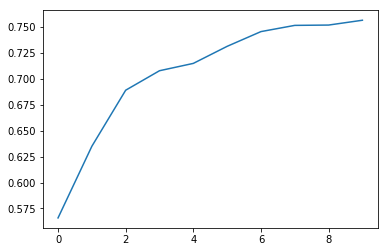

In [27]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

* However, it doesn't appear to improve much as you get above 5 trees.

In [28]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print(f'R^2 val: {m.score(X_valid, y_valid)}')

R^2 val: 0.7809096924387907


In [29]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print(f'R^2 val: {m.score(X_valid, y_valid)}')

R^2 val: 0.7840461147967512


In [30]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print(f'R^2 val: {m.score(X_valid, y_valid)}')

R^2 val: 0.7769991439754395


* Expect some point where adding more trees doesn't help that much.
  * First hyperparameter to set = `n_estimators`.

## 01:10:07 - Out-of-bag (OOB) score

* Sometimes dataset is small and you don't want to pull out a validation set: OOB score helps.
* Since creating trees doesn't use all data in the training set, could create a validation set for each tree.
  * Then calculate the error on training set, but only use the items which the tree wasn't trained on to make predictions.
  * Score available as `oob_score_` in Scikit-learn.

In [31]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [32]:
print(m.oob_score_)

0.8557801416628087


* Can use oob score with grid search to find best hyperparameters.

## 01:14:45 - Subsampling

* Instead of taking a subset of data when feeding into the forest, use a subset of the same size when creating trees.
* Fast.ai library has a function `set_rf_samples` that hacks it into RandomForest

In [33]:
set_rf_samples

<function fastai.structured.set_rf_samples(n)>

In [34]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [35]:
len(X_train)

20000

In [36]:
set_rf_samples(20000)

In [38]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, oob_score=True)
%time m.fit(X_train, y_train)

CPU times: user 11.7 s, sys: 129 ms, total: 11.8 s
Wall time: 1.88 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [40]:
print(f'R^2 val: {m.score(X_valid, y_valid)}')

R^2 val: 0.8126480173042334


### 01:18:26 - Audience questions

* Q1: How does the OOB score work when using `set_rf_samples`?
* A1: The current version doesn't change how OOB is calculated, so you need to make `oob_score=False`.

* When doing analysis, generally best to use small subsets, especially when trying to figure out which features are important.
  * Want a large enough sample size to have reasonable accuracy, but small enough so it runs quickly.

### 01:21:19 - Other hyperparameters

In [41]:
reset_rf_samples()

In [42]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, oob_score=True)
%time m.fit(X_train, y_train)
print(f'R^2 val: {m.score(X_valid, y_valid)}')

CPU times: user 11.6 s, sys: 98.2 ms, total: 11.7 s
Wall time: 1.9 s
R^2 val: 0.8138654309853924


* `min_samples_leaf`: stop training when leaf nodes have 3 or less samples.
  * Should generalise better but each tree less powerful on its own.
  * Values like 1, 3, 5, 10, 25 work well.
  * Big dataset might want a very big value like 100s or 1000s.

In [43]:
m = RandomForestRegressor(n_jobs=-1, min_samples_leaf=3, n_estimators=40, oob_score=True)
%time m.fit(X_train, y_train)
print(f'R^2 val: {m.score(X_valid, y_valid)}')

CPU times: user 9.35 s, sys: 60.9 ms, total: 9.41 s
Wall time: 1.54 s
R^2 val: 0.8131193501076375


* `max_features`: for each tree, only use a subset of columns: encourages less correlated trees.
  * 0.5: randomly choose half.
  * 1: default (choose all).
  * `sqrt`: sqrt of features.
  * `log2`: log2 of features.

In [44]:
m = RandomForestRegressor(n_jobs=-1, min_samples_leaf=3, max_features=0.5, n_estimators=40, oob_score=True)
%time m.fit(X_train, y_train)
print(f'R^2 val: {m.score(X_valid, y_valid)}')

CPU times: user 4.92 s, sys: 48.7 ms, total: 4.97 s
Wall time: 935 ms
R^2 val: 0.8263757591024465


In [45]:
print(f'RMSE val: {rmse(m.predict(X_valid), y_valid)}')

RMSE val: 0.31180364872294014


* A linear model tends to require more feature engineering, whereas random forest are "harder to screw up".
  * Trees are infinitely flexible, can use multiple splits to find out any bit of information.
  * Can be helpful to order categorical data, but if not, it would just take a few extra splits.

## 01:34:11 - Assignment

* Experiment with Random Forests.
  * Draw trees
  * Plot errors etc.
* Write your own versions of $r^2$